In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import tqdm
from torch.utils.tensorboard import SummaryWriter

In [104]:
device = torch.device("cpu")

In [112]:
image_size = 32
batch_size = 64
channels = 1

dataset = torchvision.datasets.ImageFolder(
    root="data",
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((image_size, image_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Grayscale(num_output_channels=channels)
    ]),
    is_valid_file=lambda x: x.startswith("data/thumbnails128x128/")
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(f"Datset size: {len(dataset)}")
print(f"Dataloader size: {len(dataloader)}")

Datset size: 70000
Dataloader size: 1094


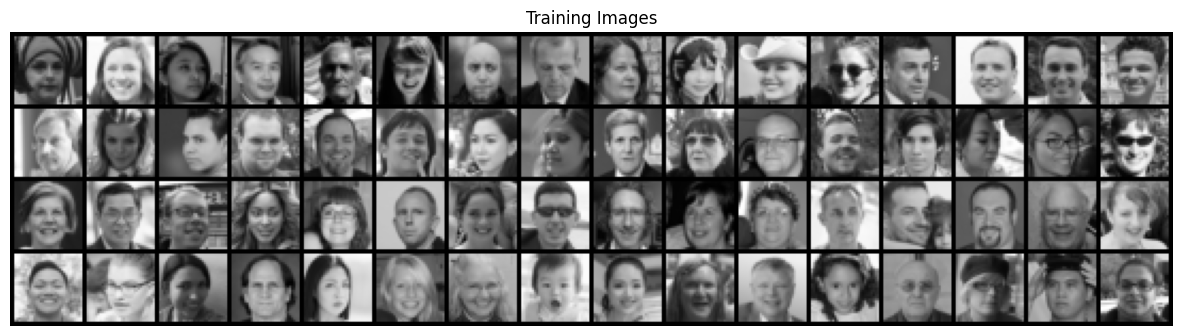

In [106]:
x, _ = next(iter(dataloader))

plt.figure(figsize=(15, 10))
plt.imshow(torchvision.utils.make_grid(x, nrow=16).permute(1, 2, 0))
plt.title("Training Images")
plt.axis("off")
plt.show()

In [113]:
class Generator(nn.Module):
    def __init__(self, image_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, image_size * image_size),
            nn.Tanh(),
        )
        self.image_size = image_size

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, self.image_size, self.image_size)
        return img
    
class Discriminator(nn.Module):
    def __init__(self, image_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size * image_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
        self.image_size = image_size

    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)
        return output
    
generator = Generator(image_size)
discriminator = Discriminator(image_size)

generator = generator.to(device)
discriminator = discriminator.to(device)

generator = torch.jit.script(generator)
discriminator = torch.jit.script(discriminator)

criterion = nn.BCELoss()

lr = 0.001

d_optimizer = optim.SGD(discriminator.parameters(), lr=lr, momentum=0.9)
d_scheduler = optim.lr_scheduler.LinearLR(d_optimizer, end_factor=0, total_iters=10)
g_optimizer = optim.SGD(generator.parameters(), lr=lr, momentum=0.9)
g_scheduler = optim.lr_scheduler.LinearLR(g_optimizer, end_factor=0, total_iters=10)


def param_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def ram_usage(model):
    return sum(p.numel() * p.element_size() for p in model.parameters() if p.requires_grad)

print(f"Generator has {param_count(generator):,} parameters and uses {ram_usage(generator)/1024/1024:,.2f} MB of RAM")
print(f"Discriminator has {param_count(discriminator):,} parameters and uses {ram_usage(discriminator)/1024/1024:,.2f} MB of RAM")

Generator has 1,732,352 parameters and uses 6.61 MB of RAM
Discriminator has 1,705,985 parameters and uses 6.51 MB of RAM


In [114]:
filename = input("Enter a filename for the model: ")

writer = SummaryWriter("logs/" + filename)

writer.add_hparams(
    hparam_dict={
        "lr": lr,
        "batch_size": batch_size,
        "image_size": image_size,
        "channels": channels,
        "Generator Parameters": param_count(generator),
        "Discriminator Parameters": param_count(discriminator),
        "Generator RAM Usage": ram_usage(generator),
        "Discriminator RAM Usage": ram_usage(discriminator),
    },
    metric_dict={},
)

writer.add_graph(generator, torch.randn(1, 100, device=device))
writer.add_graph(discriminator, torch.randn(1, 1, image_size, image_size, device=device))

for epoch in range(10):
    for idx, (real_imgs, _) in tqdm.tqdm(
        enumerate(dataloader),
        total=len(dataloader),
        desc=f"Epoch [{epoch}/{10}]",
        unit="batches",
    ):
        # Create helper variables
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        real = torch.ones(batch_size, 1, requires_grad=True, device=device)
        fake = torch.zeros(batch_size, 1, requires_grad=True, device=device)

        # Train Discriminator
        z = torch.randn(batch_size, 100, device=device)

        fake_imgs = generator(z)

        d_optimizer.zero_grad()
        real_outputs = discriminator(real_imgs)
        d_loss_real = criterion(real_outputs, real)

        fake_outputs = discriminator(fake_imgs)
        d_loss_fake = criterion(fake_outputs, fake)

        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, 100, device=device)
        fake_imgs = generator(z)
        fake_outputs = discriminator(fake_imgs)
        g_loss = criterion(fake_outputs, real)

        g_loss.backward()
        g_optimizer.step()

        if idx % 100 == 0:
            # print(f"Epoch [{epoch}/{10}], Step [{idx}/{len(dataloader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
            with torch.no_grad():
                fake = generator(z)
                fake = fake.view(fake.size(0), 1, image_size, image_size)
                fake = nn.functional.interpolate(fake, scale_factor=2, mode="nearest")
                fake = torchvision.utils.make_grid(fake, nrow=16)
                writer.add_image("Generated Images", fake, global_step=epoch * len(dataloader) + idx)

            
            
            writer.add_scalar(
                "Generator Loss",
                g_loss.item(),
                global_step=epoch * len(dataloader) + idx,
            )
            writer.add_scalar(
                "Discriminator Loss",
                d_loss.item(),
                global_step=epoch * len(dataloader) + idx,
            )

            writer.add_scalar(
                "Generator Learning Rate",
                g_scheduler.get_last_lr()[0],
                global_step=epoch * len(dataloader) + idx,
            )
            writer.add_scalar(
                "Discriminator Learning Rate",
                d_scheduler.get_last_lr()[0],
                global_step=epoch * len(dataloader) + idx,
            )

            for layer in discriminator.model:
                if hasattr(layer, "weight"):
                    writer.add_histogram(
                        "Discriminator Weights", layer.weight, global_step=epoch
                    )
                    writer.add_histogram(
                        "Discriminator Gradients", layer.weight.grad, global_step=epoch
                    )

            for layer in generator.model:
                if hasattr(layer, "weight"):
                    writer.add_histogram("Generator Weights", layer.weight, global_step=epoch)
                    writer.add_histogram(
                        "Generator Gradients", layer.weight.grad, global_step=epoch
                    )
                    
            writer.flush()

    d_scheduler.step()
    g_scheduler.step()
    
    

    
writer.close()

/Users/karan/Coding/repos/celebritycreator/.venv/lib/python3.10/site-packages/torch/jit/_trace.py:795: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  warnings.warn(
Epoch [9/10]: 100%|██████████| 1094/1094 [01:58<00:00,  9.20batches/s]


In [ ]:
rand_z = torch.randn(16, 100, device=device)
fake_imgs = generator(rand_z)
plt.figure(figsize=(20, 20))
plt.imshow(torchvision.utils.make_grid(fake_imgs, nrow=4).permute(1, 2, 0).cpu().detach().numpy())
plt.title("Generated Images")
plt.axis("off")

In [ ]:
rand_z = torch.randn(16, 100, device=device)
fake_imgs = generator(rand_z)
plt.figure(figsize=(20, 20))
plt.imshow(torchvision.utils.make_grid(fake_imgs, nrow=4).permute(1, 2, 0).cpu().detach().numpy())
plt.title("Generated Images")
plt.axis("off")